In [1]:
import pandas as pd
import numpy as np

from scipy.stats import linregress
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import ttest_rel

import matplotlib.pyplot as plt 

# set plot parameters
params = {'legend.fontsize': 18,
          'figure.figsize': (16, 12),
          'lines.linewidth': 3,
          'axes.labelsize': 24,
          'axes.titlesize':24,
          'axes.linewidth':3,
          'boxplot.boxprops.linewidth':3.0,
          'boxplot.capprops.linewidth': 3.0,
          'boxplot.flierprops.linewidth': 3.0,
          'boxplot.medianprops.color': 'C0',
          'boxplot.medianprops.linestyle': '-',
          'boxplot.medianprops.linewidth': 3.0,
          'xtick.labelsize':20,
          'ytick.labelsize':20}
plt.rcParams.update(params)
plt.style.use('seaborn-colorblind')
plt.rcParams['pdf.fonttype'] = 42

In [2]:
models = ['RNN', 'MiRNN']
n_splits = [20]
n_trials = 10

# specify species and metabolite names 
df = pd.read_csv("../Data/2021_02_19_MultifunctionalDynamicData.csv")
sys_vars = df.columns.values[2:]
species = df.columns.values[2:-4]
metabolites =  df.columns.values[-4:]
controls = []
system_variables = np.concatenate((np.array(species), np.array(metabolites)))
system_variables

array(['PC_OD', 'PJ_OD', 'BV_OD', 'BF_OD', 'BO_OD', 'BT_OD', 'BC_OD',
       'BY_OD', 'BU_OD', 'DP_OD', 'BL_OD', 'BA_OD', 'BP_OD', 'CA_OD',
       'EL_OD', 'FP_OD', 'CH_OD', 'AC_OD', 'BH_OD', 'CG_OD', 'ER_OD',
       'RI_OD', 'CC_OD', 'DL_OD', 'DF_OD', 'Butyrate', 'Acetate',
       'Lactate', 'Succinate'], dtype=object)

In [3]:
score_dict = {}

for model in models:
    
    # for each k fold 
    for n_split in n_splits:
        
        # for each output
        for i, variable in enumerate(sys_vars):
        
            # record performance from each trial
            R_scores = []
            mse_values = []
        
            # for each k-fold trial 
            for k in range(n_trials):

                df_kfold = pd.read_csv(f"Kfold/{model}_{n_split}_fold_{k+1}.csv")
                y = df_kfold[variable + ' true'].values

                # remove known initial condition when comparing measured vs. predicted
                time_zero = np.in1d(df_kfold.Time.values, 0.)
                y = y[~time_zero]    
                y_pred = df_kfold[variable + ' pred'].values[~time_zero]
                
                # remove known zeros
                # inds_zero = y == 0
                # y = y[~inds_zero]
                # y_pred = y_pred[~inds_zero]

                # record Pearson correlation coefficient (R)
                R_scores.append(linregress(y, y_pred).rvalue)
                mse_values.append(mse(y, y_pred))

            # save scores
            score_dict[model + f" {variable} {n_split} R"] = R_scores
            score_dict[model + f" {variable} {n_split} mse"] = mse_values

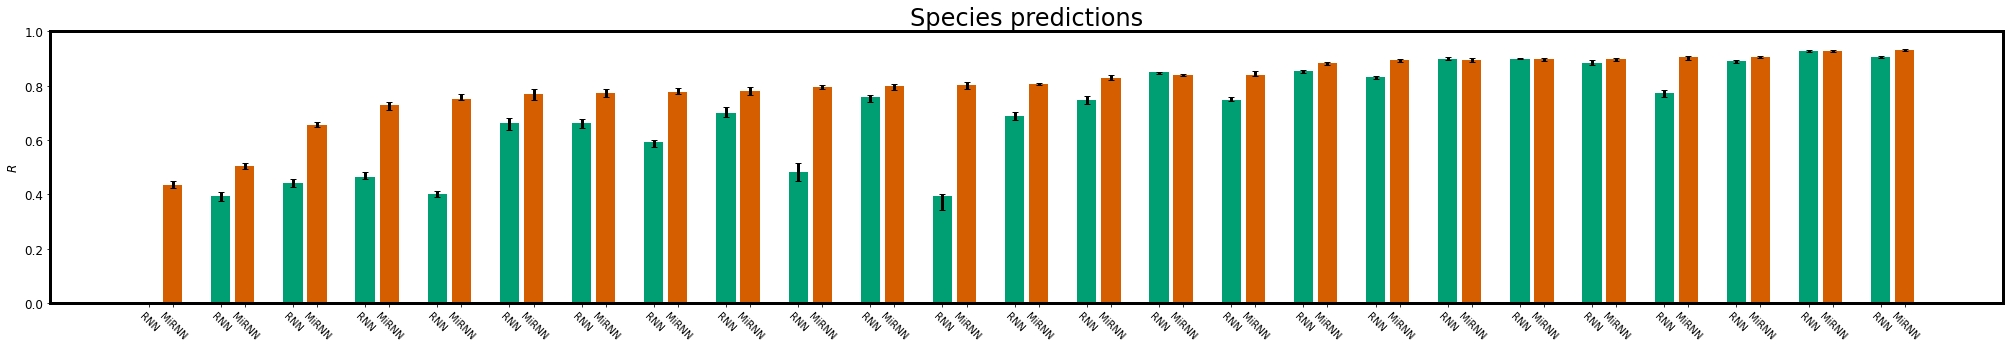

['FP_OD' 'EL_OD' 'BH_OD' 'BL_OD' 'CA_OD' 'CC_OD' 'BV_OD' 'BP_OD' 'RI_OD'
 'BU_OD' 'DP_OD' 'PC_OD' 'CH_OD' 'CG_OD' 'DL_OD' 'BY_OD' 'BA_OD' 'DF_OD'
 'ER_OD' 'AC_OD' 'BT_OD' 'BO_OD' 'PJ_OD' 'BC_OD' 'BF_OD']


In [4]:
for n_split in n_splits:
    
    scores = []
    medians = []
    heights = []
    errs = []
    positions = []
    labels = []
    colors = []
    position_counter = 0

    # sort species 
    for variable in species:
        medians.append(np.median(score_dict[f'MiRNN {variable} {n_split} R']))
    arangement = np.argsort(medians)
    
    for variable in species[arangement]:
        for model in models:
            middle = np.median(score_dict[f'{model} {variable} {n_split} R'])
            heights.append(middle)
            quantiles = np.quantile(score_dict[f'{model} {variable} {n_split} R'], [.25, .75])
            errs.append([middle-quantiles[0], quantiles[-1]-middle])
            positions.append(position_counter)
            position_counter+=1
            labels.append(model)
        colors += ['C1', 'C2']
        position_counter+=1
        
    # set plot parameters
    params = {'xtick.labelsize':10,
              'ytick.labelsize':12}
    plt.rcParams.update(params)    

    plt.figure(figsize=(35, 5))
    plt.bar(x=positions,
            height=heights, 
            yerr= np.stack(errs).T,
            capsize=3,
            tick_label=labels,
            color=colors)

    plt.ylabel(r"$R$", fontsize=12)
    plt.xticks(rotation=-45)
    plt.title("Species predictions")
    plt.ylim([0, 1.])
    plt.savefig("rnn_species_predictions.pdf", dpi=300)
    plt.show()
print(species[arangement])

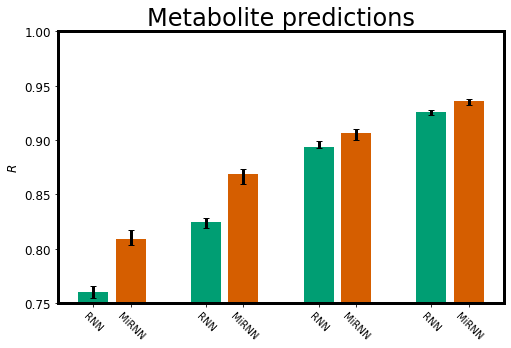

['Acetate' 'Succinate' 'Lactate' 'Butyrate']


In [5]:
for n_split in n_splits:
    
    scores = []
    medians = []
    heights = []
    errs = []
    positions = []
    labels = []
    colors = []
    position_counter = 0

    # sort species 
    for variable in metabolites:
        medians.append(np.median(score_dict[f'MiRNN {variable} {n_split} R']))
    arangement = np.argsort(medians)
    
    for variable in metabolites[arangement]:
        for model in models:
            middle = np.median(score_dict[f'{model} {variable} {n_split} R'])
            heights.append(middle)
            quantiles = np.quantile(score_dict[f'{model} {variable} {n_split} R'], [.25, .75])
            errs.append([middle-quantiles[0], quantiles[-1]-middle])
            positions.append(position_counter)
            position_counter+=1
            labels.append(model)
        colors += ['C1', 'C2']
        position_counter+=1
        
    # set plot parameters
    params = {'xtick.labelsize':10,
              'ytick.labelsize':12}
    plt.rcParams.update(params)    

    plt.figure(figsize=(8, 5))
    plt.bar(x=positions,
            height=heights, 
            yerr= np.stack(errs).T,
            capsize=3,
            tick_label=labels,
            color=colors)

    plt.ylabel(r"$R$", fontsize=12)
    plt.xticks(rotation=-45)
    plt.title("Metabolite predictions")
    plt.ylim([.75, 1.])
    plt.savefig("rnn_metabolite_predictions.pdf", dpi=300)
    plt.show()
print(metabolites[arangement])

# Compare predicted Log-Likelihood 

In [6]:
LL_df = pd.read_csv("MiRNN_LL_results.csv")
LL_df

,k,LL Pred,LL Fix
0,1,5323.381318,3564.068989
1,2,5223.874663,3216.109894
2,3,5330.524202,3039.050770
3,4,5513.791971,3509.984490
4,5,5181.545386,2818.775757
5,6,5316.343279,3598.221280
6,7,5402.084857,3321.086892
7,8,5149.977872,3244.977467
8,9,5315.942938,3379.546425
9,10,5297.453216,3376.134984


In [7]:
LL_stats = np.quantile(LL_df[['LL Pred', 'LL Fix']].values, [.25, .5, .75], axis=0)
LL_errs  = np.zeros([2,2])
LL_errs[0] = LL_stats[1] - LL_stats[0]
LL_errs[1] = LL_stats[2] - LL_stats[1]
LL_stats

array([[5242.26930133, 3223.3267876 ],
       [5316.14310829, 3348.61093772],
       [5328.73848061, 3477.3749739 ]])

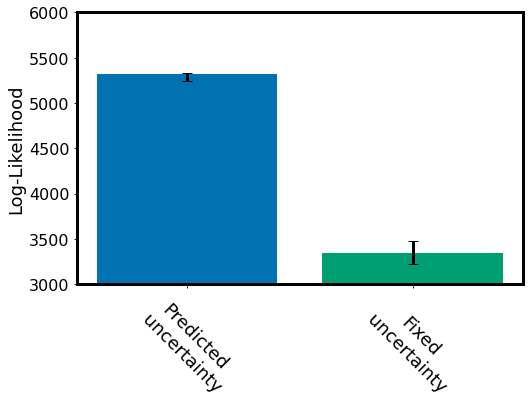

In [8]:
# set plot parameters
params = {'xtick.labelsize':10,
          'ytick.labelsize':12}
plt.rcParams.update(params)    

heights = LL_df[['LL Pred', 'LL Fix']].values

plt.figure(figsize=(8, 5))
plt.bar(x=[0,1],
        height= LL_stats[1, :], 
        yerr  = LL_errs,
        capsize=5,
        tick_label=['Predicted\n uncertainty', 'Fixed\n uncertainty'],
        color=['C0','C1'])

plt.ylabel(r"Log-Likelihood", fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=18, rotation=-45)
#plt.title("Species predictions")
plt.ylim([3000, 6000])
# plt.savefig("Results/LL_comparison.pdf", dpi=300)
plt.show()